# 第 5 章 泰坦尼克幸存者预测

## 5.1 处理数据集

In [1]:
# 导入几个基本库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.dpi'] = 180

In [2]:
df = pd.read_csv('data/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df['Survived'].mean()

0.3838383838383838

In [4]:
calss_grouping = df.groupby('Pclass').mean()
calss_grouping

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


<AxesSubplot:xlabel='Pclass,Sex'>

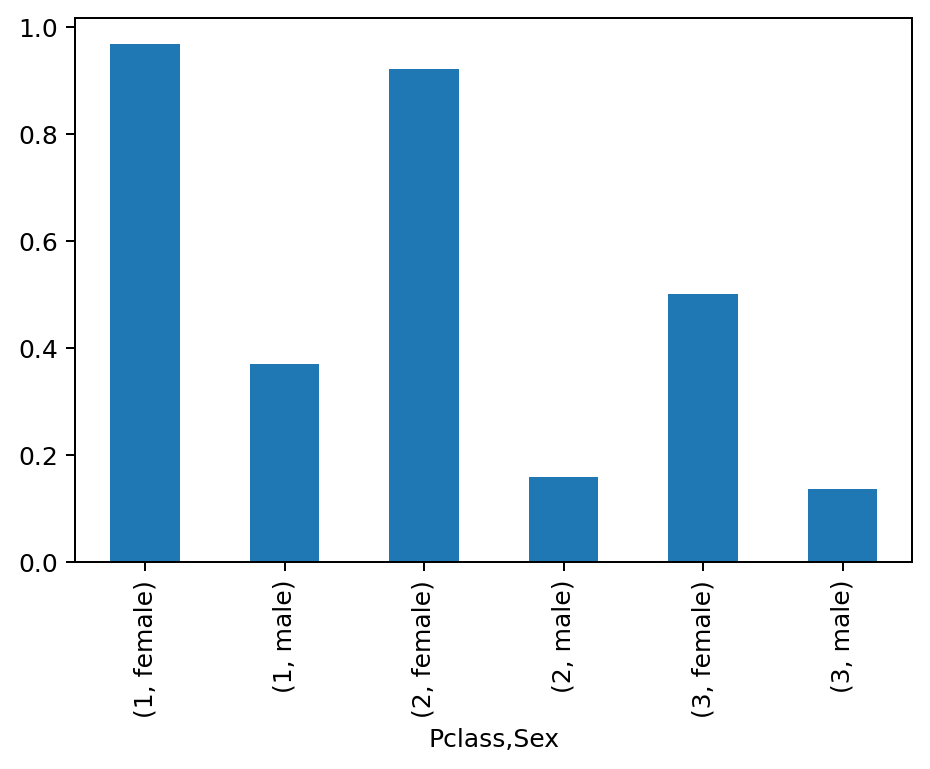

In [5]:
class_sex_grouping = df.groupby(['Pclass','Sex']).mean()
class_sex_grouping['Survived'].plot.bar()

<AxesSubplot:xlabel='Age'>

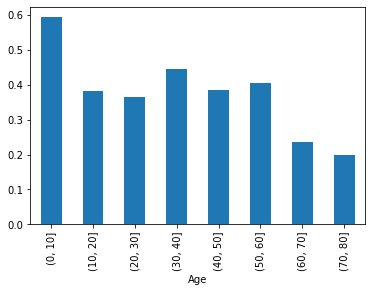

In [22]:
group_by_age = pd.cut(df["Age"], np.arange(0, 90, 10))
age_grouping = df.groupby(group_by_age).mean()
age_grouping['Survived'].plot.bar()

In [7]:
def preprocess_dataset(data_frame):
    # 先复制产生一个新的数据集，这样我们的原始数据集不会被修改
    data_frame = data_frame.copy()

    # 丢弃缺失年龄，性别和登船口岸信息的数据
    data_frame = data_frame.dropna(subset=['Age', 'Sex', 'Embarked', 'Fare'])

    # 把性别从 male, female 转换成 0 和 1
    data_frame.Sex = data_frame.Sex.replace(['male', 'female'], value=[0, 1])

    # 把登船口岸从 S, C, Q 转换成 0, 1, 2
    data_frame.Embarked = data_frame.Embarked.replace(['S', 'C', 'Q'], value=[0, 1, 2])

    # 丢弃我们不需要的字段
    data_frame = data_frame.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])
    return data_frame

train_data = preprocess_dataset(df)

In [8]:
train_labels = train_data.pop('Survived')

## 5.2 定义模型

In [9]:
import tensorflow.keras as keras

# 使用 L 代表 keras.layers ，方便后续调用
L = keras.layers

model = keras.Sequential([
    # 添加一个包含 24 个神经元的全连接层，输入维度为 7，输出维度 12
    L.Dense(24, input_dim=7, activation='relu', name='input_layer'),
    # 添加一个包含 12 个神经元的全连接层，上层的输出为本层的输入
    L.Dense(12, activation='relu', name='hidden_layer'),
    # 添加一个包含 1 个神经元的全连接层，使用 sigmoid 函数来确保网络输出在 0 和 1 之间
    L.Dense(1, activation='sigmoid', name='output_layer')
])

## 5.3 编译模型

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 24)                192       
_________________________________________________________________
hidden_layer (Dense)         (None, 12)                300       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 13        
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


In [11]:
def build_model() -> keras.Sequential:
    model = keras.Sequential([
        # 添加一个包含 24 个神经元的全连接层，输入维度为 7，输出维度 12
        L.Dense(24, input_dim=7, activation='relu', name='input_layer'),
        # 添加一个包含 12 个神经元的全连接层，上层的输出为本层的输入
        L.Dense(12, activation='relu', name='hidden_layer'),
        # 添加一个包含 1 个神经元的全连接层，使用 sigmoid 函数来确保网络输出在 0 和 1 之间
        L.Dense(1, activation='sigmoid', name='output_layer')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## 5.4 训练模型

In [12]:
model.fit(train_data.values, train_labels.values, epochs=20)

Epoch 1/20
23/23 [==============================] - 0s 783us/step - loss: 10.1016 - accuracy: 0.4045
Epoch 2/20
23/23 [==============================] - 0s 739us/step - loss: 5.8311 - accuracy: 0.4045
Epoch 3/20
23/23 [==============================] - 0s 695us/step - loss: 2.6551 - accuracy: 0.3862
Epoch 4/20
23/23 [==============================] - 0s 696us/step - loss: 0.9872 - accuracy: 0.4073
Epoch 5/20
23/23 [==============================] - 0s 696us/step - loss: 0.6731 - accuracy: 0.6573
Epoch 6/20
23/23 [==============================] - 0s 739us/step - loss: 0.6387 - accuracy: 0.6587

## 5.5 评估模型

In [13]:
from sklearn.model_selection import KFold

data_set = [1,2,3,4,5,6,7,8,9]

# 初始化一个 KFold 对象，n_splits 表示分区数量。
kfold = KFold(n_splits=3)

for train, test in kfold.split(data_set, None):
    print(f'train: {train}, test: {test}')

train: [3 4 5 6 7 8], test: [0 1 2]
train: [0 1 2 6 7 8], test: [3 4 5]
train: [0 1 2 3 4 5], test: [6 7 8]


In [14]:
# 处理原始数据集
train_data = preprocess_dataset(df)

# 保存准确率列表和模型训练记录的数组
accuracy_list = []
history_list = []

# 这里我们把数据分成五个分区
kfold = KFold(n_splits=5)

for train_index, test_index in kfold.split(train_data, None):

    # 使用数据索引获取训练和测试数据
    # 注意这里使用 `copy` 方法是因为我们会对这个数据进行编辑
    # 使用 copy 后不会修改原始数据
    train = train_data.iloc[train_index].copy()
    test =  train_data.iloc[test_index].copy()

    train_label = train.pop('Survived')
    test_label = test.pop('Survived')

    # 获取新的模型
    model = build_model()
    # 训练数据并获取训练记录
    # validation_split 表示我们随机取 20% 的数据用于验证，剩余数据用于训练
    history = model.fit(train.values,
                        train_label.values,
                        validation_split=0.2,
                        verbose=0,
                        epochs=100)

    # 使用测试集测试模型
    loss, accuracy = model.evaluate(test.values, test_label.values)
    accuracy_list.append(accuracy)
    history_list.append(history)

print(accuracy_list)

5/5 [==============================] - 0s 597us/step - loss: 0.3939 - accuracy: 0.8169
[0.748251736164093, 0.7832167744636536, 0.7394366264343262, 0.7464788556098938, 0.8169013857841492]


<Figure size 1080x720 with 0 Axes>

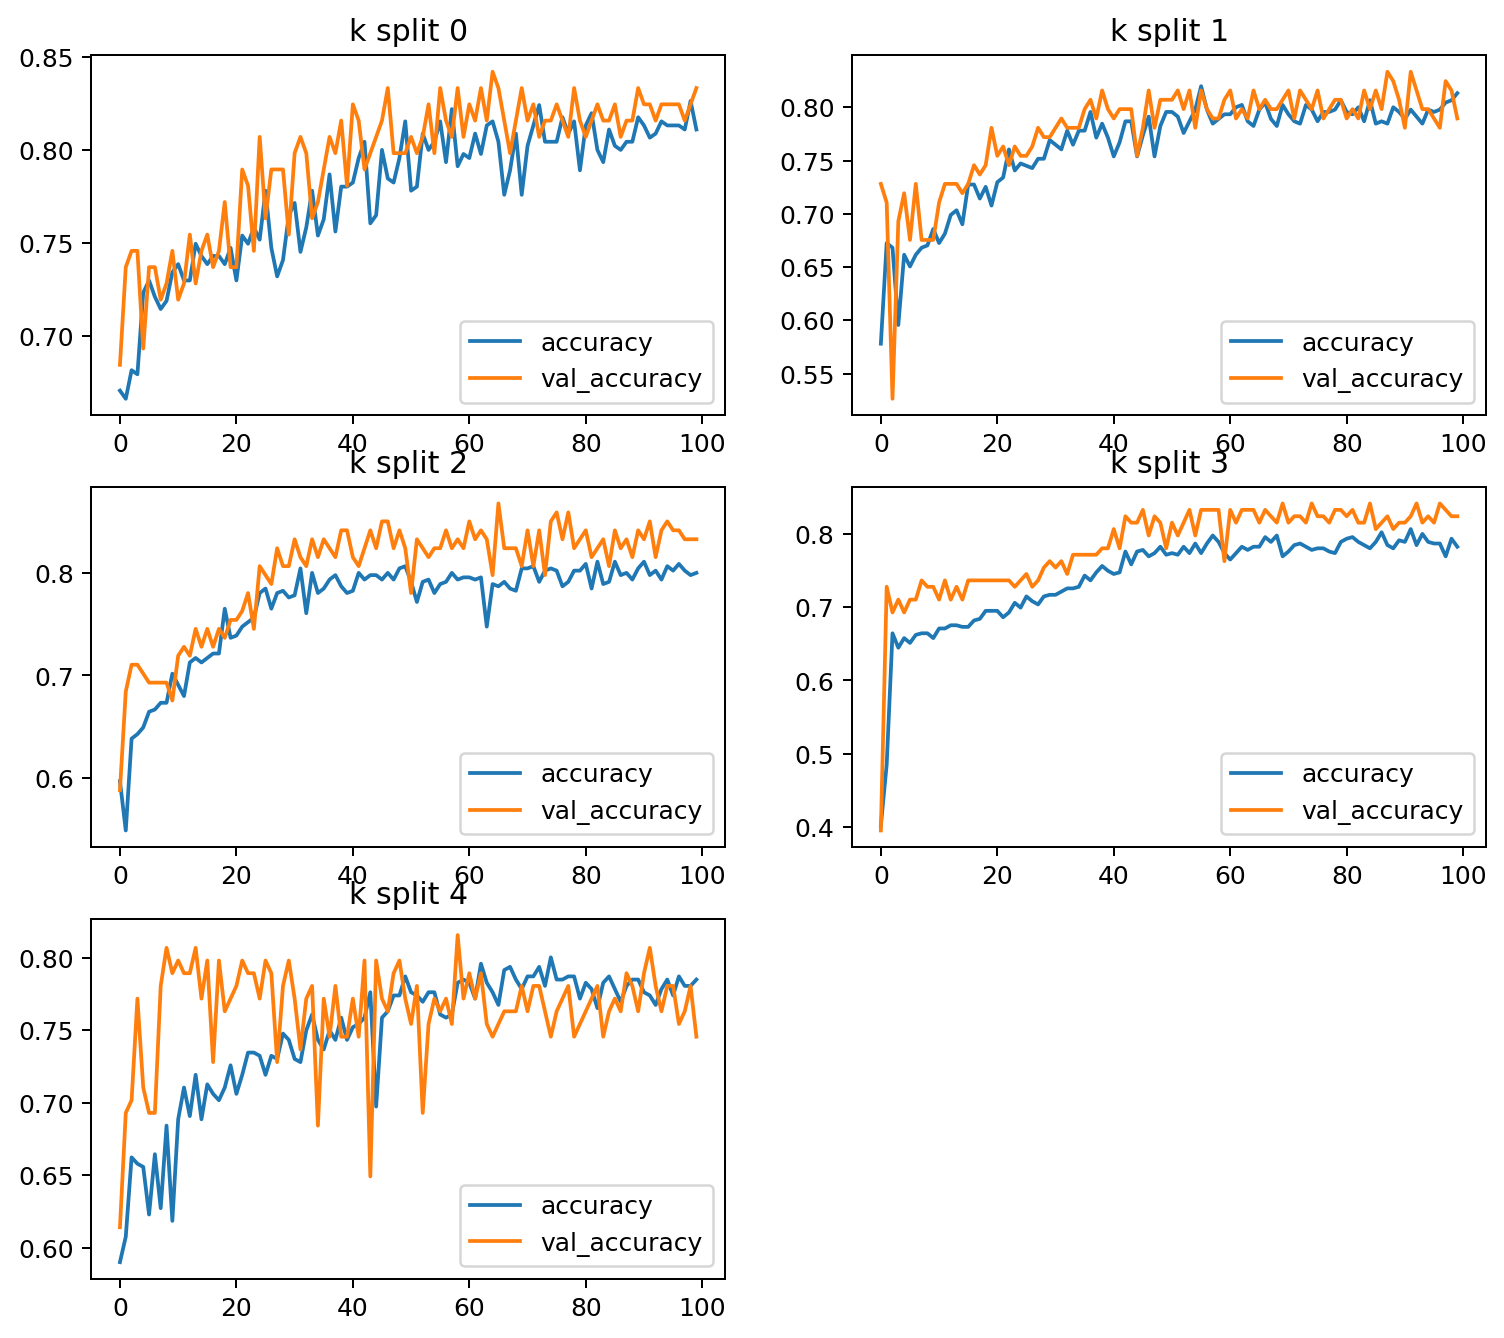

In [15]:
plt.figure()
# 设定子图大小
plt.subplots(figsize=(10,9))
for index, his in enumerate(history_list):
    plt.subplot(3, 2, index + 1)
    plt.plot(his.history['accuracy'], label='accuracy')
    plt.plot(his.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title(f'k split {index}') # 添加图形标题
plt.show()

## 5.7 预测

In [16]:
# 读取测试数据
raw_test_df = pd.read_csv('data/titanic/test.csv')
# 处理测试数据集，训练数据和测试数据特征要用同样的处理方法
# 这样才能获取正确的预测结果
test_df = preprocess_dataset(raw_test_df)

In [17]:
model.predict(test_df[:10].values)

array([[0.180271  ],
       [0.52905434],
       [0.22522247],
       [0.13333675],
       [0.62971735],
       [0.18173793],
       [0.698597  ],
       [0.20514092],
       [0.7244523 ],
       [0.10207561]], dtype=float32)

In [18]:
model.predict_classes(test_df[:10].values)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

## 5.6 代码汇总

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 定义数据处理方法
def preprocess_dataset(data_frame):
    # 先复制产生一个新的数据集，这样我们的原始数据集不会被修改
    data_frame = data_frame.copy()

    # 丢弃缺失年龄，性别和登船口岸信息的数据
    data_frame = data_frame.dropna(subset=['Age', 'Sex', 'Embarked', 'Fare'])

    # 把性别从 male, female 转换成 0 和 1
    data_frame.Sex = data_frame.Sex.replace(['male', 'female'], value=[0, 1])

    # 把登船口岸从 S, C, Q 转换成 0, 1, 2
    data_frame.Embarked = data_frame.Embarked.replace(['S', 'C', 'Q'], value=[0, 1, 2])

    # 丢弃我们不需要的字段
    data_frame = data_frame.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])
    return data_frame

# 读取和处理训练数据数据
df = pd.read_csv('data/titanic/train.csv')
train_df = preprocess_dataset(df)

# 拆分特征和标签
train_labels = train_df.pop('Survived')

# 定义模型
from tensorflow.python import keras

# 使用 L 代表 keras.layers ，方便后续调用
L = keras.layers

model = keras.Sequential([
    # 添加一个包含 12 个神经元的全连接层，输入维度为 7，输出维度 12
    L.Dense(12, input_dim=7, activation='relu', name='input_layer'),
    # 添加一个包含 6 个神经元的全连接层，上层的输出为本层的输入
    L.Dense(6, activation='relu', name='hidden_layer'),
    # 添加一个包含 1 个神经元的全连接层，使用 sigmoid 函数来确保网络输出在 0 和 1 之间
    L.Dense(1, activation='sigmoid', name='output_layer')
])

# 编译模型
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 输出模型概述
model.summary()

# 训练模型
model.fit(train_df, train_labels, epochs=20)

# 评估模型
score = model.evaluate(train_df, train_labels)
print(f"loss: {score[0]}, accuracy: {score[1]*100}%")

# 读取和准备测试数据
raw_test_df = pd.read_csv('data/titanic/test.csv')
test_df = preprocess_dataset(raw_test_df)
print(model.predict_classes(test_df[:10]))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 12)                96        
_________________________________________________________________
hidden_layer (Dense)         (None, 6)                 78        
_________________________________________________________________
output_layer (Dense)         (None, 1)                 7         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
23/23 [==============================] - 0s 609us/step - loss: 10.7897 - accuracy: 0.4045
Epoch 2/20
23/23 [==============================] - 0s 653us/step - loss: 6.9529 - accuracy: 0.4045
Epoch 3/20
23/23 [==============

In [20]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2021-10-29 10:04:06
